
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW-Q : Overtopping estimation of historical nearshore storms at 3 locations

inputs required: 
  * Historical DWTs
  * MU - TAU intradaily hidrographs time series
  * Historical water levels

in this notebook:
  * Transform storms into hourly time series
  * HyCReWW-Q overtopping estimation of historical events
  

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from datetime import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize

from teslakit.util.time_operations import npdt64todatetime, fast_reindex_hourly, repair_times_hourly, add_max_storms_mask
   



## Database and Site parameters

In [6]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_hindcast')


# --------------------------------------
# N, S, E profiles
pN = 28 #(36,22)
pS = 8  #(13,1)
pE = 16 #(21,14)


# --------------------------------------
# Load historical TWL
hist_TWL = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN_hindcast/TIDE/hist_TWL.nc'))


# --------------------------------------
# load Hycreww RBF coefficients and sim. variables min. and max.

# reef characteristics (AlbaR)
xds = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/datos_perfiles_albaR/data_profiles.nc')
xds = xds.drop('zBeach')
reef_N = xds.sel(profile = pN )
reef_S = xds.sel(profile = pS)
reef_E = xds.sel(profile = pE)


# Zbeach characteristics (Sara)
xds_Zbeach = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/datos_perfiles_sara/zBeach_clean_P1.nc')
xds_Zbeach = xds_Zbeach.drop({'xcoor', 'ycoor'})

Zbeach_N = xds_Zbeach.sel(profile = pN )
Zbeach_S = xds_Zbeach.sel(profile = pS)
Zbeach_E = xds_Zbeach.sel(profile = pE)


# Hycreww limits and coefficients
var_lims, rbf_coeffs = db.Load_HYCREWW_Q()


# --------------------------------------
# MU - TAU intradaily hidrographs time series
xds_mutau_N = xr.open_dataset(op.join(p_data, 'sites', 'KWAJALEIN_hindcast', 'ESTELA', 'hydrographs', 'MuTau_N.nc'))
xds_mutau_S = xr.open_dataset(op.join(p_data, 'sites', 'KWAJALEIN_hindcast', 'ESTELA', 'hydrographs', 'MuTau_S.nc'))
xds_mutau_E = xr.open_dataset(op.join(p_data, 'sites', 'KWAJALEIN_hindcast', 'ESTELA', 'hydrographs', 'MuTau_E.nc'))
print(xds_mutau_N)
print(xds_mutau_S)
print(xds_mutau_E)

# --------------------------------------
# data for plotting comparison
WAVES_N_h = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore/v4/output_Def_swells/swells_profiles_N.nc') # hourly
WAVES_S_h = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore/v4/output_Def_swells/swells_profiles_S.nc') # 3-hourly
WAVES_E_h = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore/v4/output_Def_swells/swells_profiles_E.nc') # 3-hourly


# --------------------------------------
# data for plotting comparison
WT = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_hindcast/ESTELA/pred_SLP/kma.nc')
print()
print(WT)


<xarray.Dataset>
Dimensions:         (time: 3625)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-23 1979-01-26 ... 2019-12-23
Data variables:
    MU              (time) float64 ...
    MU2             (time) float64 ...
    TAU             (time) float64 ...
    Hs              (time) float64 ...
    Tp              (time) float64 ...
    Dir             (time) float64 ...
    Runup_max       (time) float64 ...
    time_runup_max  (time) datetime64[ns] ...
    WT              (time) int64 ...
<xarray.Dataset>
Dimensions:         (time: 3625)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-23 1979-01-26 ... 2019-12-23
Data variables:
    MU              (time) float64 ...
    MU2             (time) float64 ...
    TAU             (time) float64 ...
    Hs              (time) float64 ...
    Tp              (time) float64 ...
    Dir             (time) float64 ...
    Runup_max       (time) float64 ...
    time_runup_max  (time) datetime64[ns] ...
    WT   

# Storms to hourly data

In [7]:
def Intradaily_Hydrograph(xds_mutau):
    '''
    Calculates intradaily hydrograph (hourly) from a time series of storms.
    #storms waves data (hs, tp, dir) and (mu, tau, ss) is needed.

    xds_wvs (waves aggregated):
        xarray.Dataset (time,), Hs, Tp, Dir

    xds_tcs (TCs):
        xarray.Dataset (time,), mu, tau, ss

    returns xarray.Dataset (time,), Hs, Tp, Dir, SS  (hourly)
    '''

    # input data (storms aggregated waves)
    Hs = xds_mutau.Hs.values[:]
    ts = xds_mutau.time.values[:]    
    
    
    # TODO: this should not be needed
    if isinstance(ts[0], np.datetime64):
        ts = [npdt64todatetime(x) for x in ts]
        

    # input data (storms TCs)
    tau = xds_mutau.TAU.values[:]  # storm max. instant (0-1)
    mu = xds_mutau.MU.values[:]
    #ss = xds_tcs.ss.values[:]
    
        
    # storm durations
    s_dur_h = np.array([x.total_seconds()/3600 for x in np.diff(ts)])  # hours    
    s_cs_h = np.cumsum(s_dur_h)  # hours since time start
    s_cs_h = np.insert(s_cs_h,0,0)    

    
    # storm tau max (hourly)
    tau_h = np.floor(s_cs_h[:-1] + s_dur_h * tau[:-1])
    
    
    # aux function
    def CalcHydro(vv, vt, tt, mt):
        '''
        Calculate variable hourly hydrograph.
        vv - var value at max.
        vt - var time (hours since start, at hydrograph extremes)
        tt - tau max time (hours since start).
        mt - mu value
        '''
        
        # var value at hydrographs extremes
        vv_extr = vv * np.power(2*mt-1, 2)

        
        # make it continuous
        vv_extr_cont = (np.roll(vv_extr,1) + vv_extr) / 2
        vv_extr_cont[0] = vv_extr_cont[1]
        vv_extr_cont[-1] = vv_extr_cont[-2]
        
        
        # join hydrograph max. and extremes variable data
        vt_full = np.concatenate([vt, tt])  # concatenate times (used for sorting)
        vv_full = np.concatenate([vv_extr_cont, vv])        

        
        # sort data
        ix = np.argsort(vt_full)
        vt_sf = vt_full[ix]
        vv_sf = vv_full[ix]
        
            
        # interpolate to fill all hours
        h_times = np.arange(vt_sf[0], vt_sf[-1] + 1, 1)
        
        h_values = np.interp(h_times, vt_sf, vv_sf)

        # fix times
        h_times = h_times.astype(int)
        

        return h_values, h_times
    

    # hydrograph variables: hs
    hourly_Hs, hourly_times = CalcHydro(Hs, s_cs_h, tau_h, mu)        
    
    
    # resample waves data to hourly (pad Tp and Dir)
    xds_wvs_h = fast_reindex_hourly(xds_mutau)
            
    # select wave variables
    xds_wvs_h = xds_wvs_h[['Hs','Tp','Dir']]

    # add Hs 
    xds_wvs_h['Hs'] =(('time',), hourly_Hs)

    return xds_wvs_h



In [8]:

# calculate intradaily hourly hydrographs for simulated storms
WAVES_N = Intradaily_Hydrograph(xds_mutau_N)
WAVES_S = Intradaily_Hydrograph(xds_mutau_S)
WAVES_E = Intradaily_Hydrograph(xds_mutau_E)
print(WAVES_N)
print()

# repair times: remove duplicates (if any)
WAVES_N = repair_times_hourly(WAVES_N)
WAVES_S = repair_times_hourly(WAVES_S)
WAVES_E = repair_times_hourly(WAVES_E)
print(WAVES_N)
print()

   

<xarray.Dataset>
Dimensions:  (time: 358657)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-23 1979-01-23T01:00:00 ... 2019-12-23
Data variables:
    Hs       (time) float64 0.07212 0.08197 0.09181 ... 0.1137 0.08161 0.04954
    Tp       (time) float64 3.545 3.545 3.545 3.545 ... 5.244 5.244 5.244 5.046
    Dir      (time) float64 29.24 29.24 29.24 29.24 ... 3.227 3.227 3.227 4.164

<xarray.Dataset>
Dimensions:  (time: 358657)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-23 1979-01-23T01:00:00 ... 2019-12-23
Data variables:
    Hs       (time) float64 0.07212 0.08197 0.09181 ... 0.1137 0.08161 0.04954
    Tp       (time) float64 3.545 3.545 3.545 3.545 ... 5.244 5.244 5.244 5.046
    Dir      (time) float64 29.24 29.24 29.24 29.24 ... 3.227 3.227 3.227 4.164



### Plot Hs from storms vs Hs hourly

Text(0.5, 1.0, 'East profile. pE = 16')

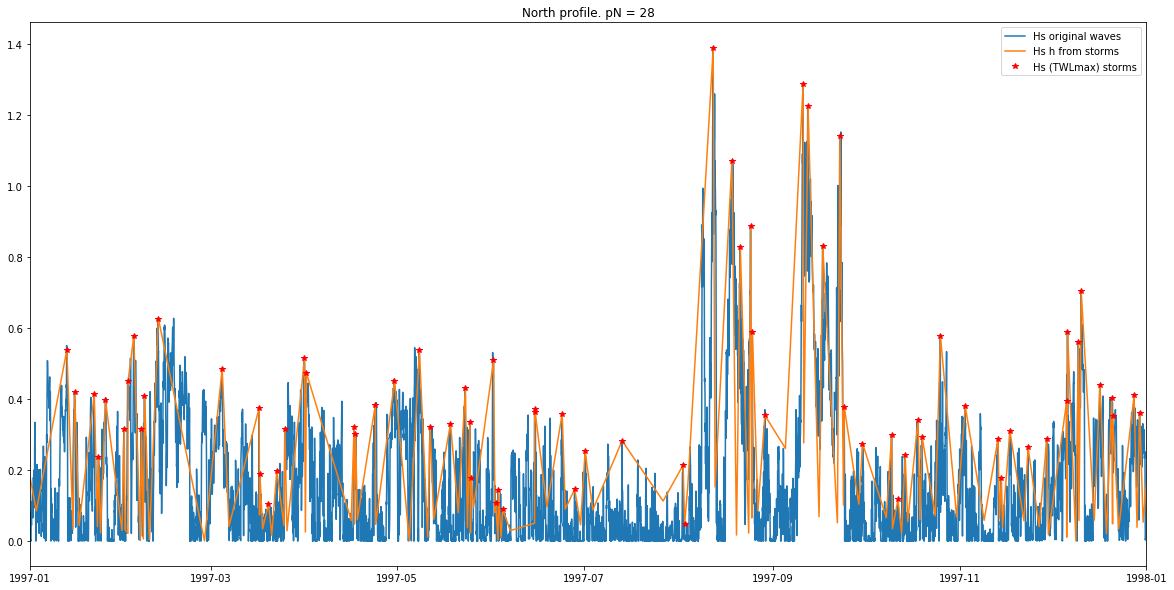

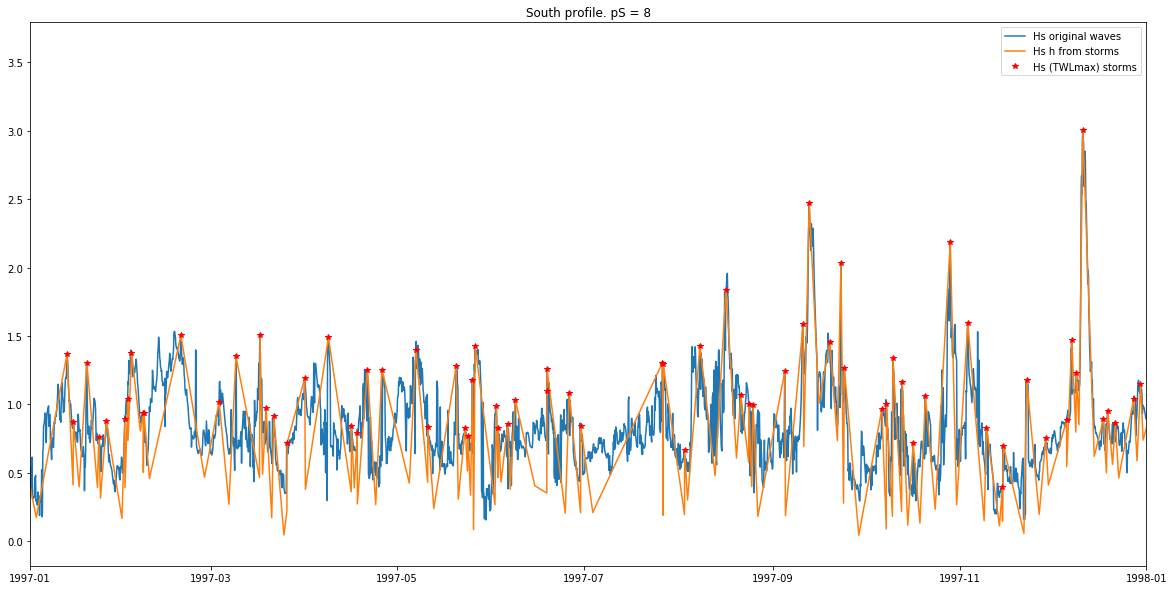

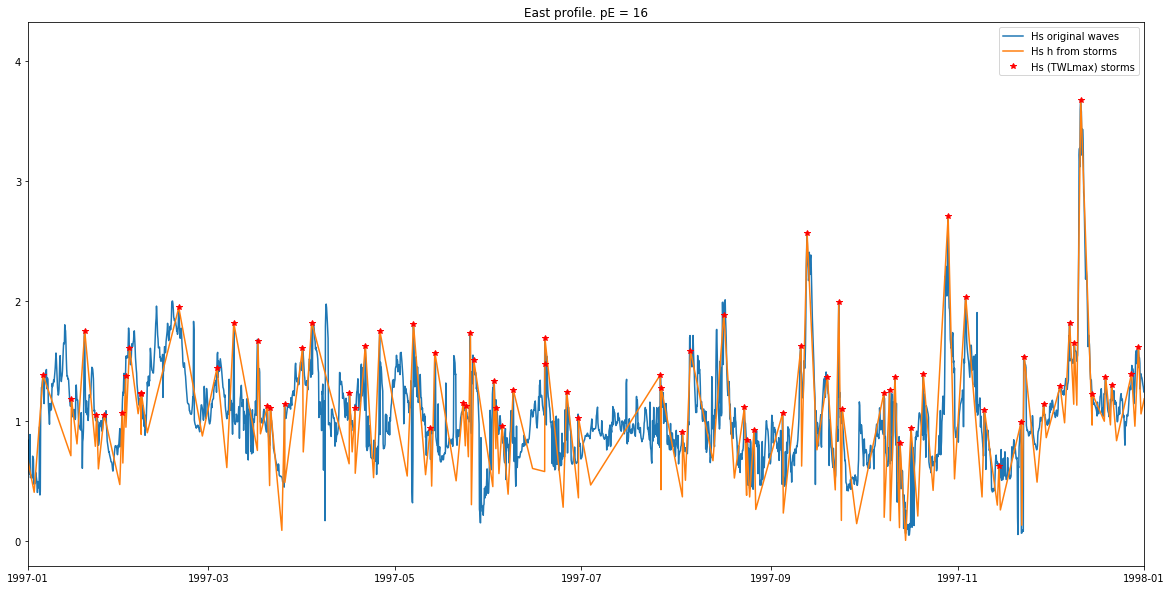

In [9]:
# --------------------------------------
# plot all profiles (1 year zoom)

WAVES_N_h = WAVES_N_h.sel(profile=pN)
WAVES_S_h = WAVES_S_h.sel(profile=pS)
WAVES_E_h = WAVES_E_h.sel(profile=pE)


# plot N
plt.figure(figsize=(20,10))
plt.plot(WAVES_N_h.time, WAVES_N_h.hs, label='Hs original waves')
plt.plot(WAVES_N.time, WAVES_N.Hs,color='C1',label='Hs h from storms')
plt.plot(xds_mutau_N.time_runup_max, xds_mutau_N.Hs, '*r',label='Hs (TWLmax) storms')
plt.legend()
plt.xlim(datetime(1997,1,1),datetime(1998,1,1))
plt.title('North profile. pN = ' + str(pN))


# plot S
plt.figure(figsize=(20,10))
plt.plot(WAVES_S_h.time, WAVES_S_h.hs, label='Hs original waves')
plt.plot(WAVES_S.time, WAVES_S.Hs, color='C1',label='Hs h from storms')
plt.plot(xds_mutau_S.time_runup_max, xds_mutau_S.Hs, '*r', label='Hs (TWLmax) storms')
plt.legend()
plt.xlim(datetime(1997,1,1),datetime(1998,1,1))
plt.title('South profile. pS = ' + str(pS))


# plot E
plt.figure(figsize=(20,10))
plt.plot(WAVES_E_h.time, WAVES_E_h.hs, label='Hs original waves')
plt.plot(WAVES_E.time, WAVES_E.Hs, color='C1',label='Hs h from storms')
plt.plot(xds_mutau_E.time_runup_max, xds_mutau_E.Hs, '*r', label='Hs (TWLmax) storms')
plt.legend()
plt.xlim(datetime(1997,1,1),datetime(1998,1,1))
plt.title('East profile. pE = ' + str(pE))



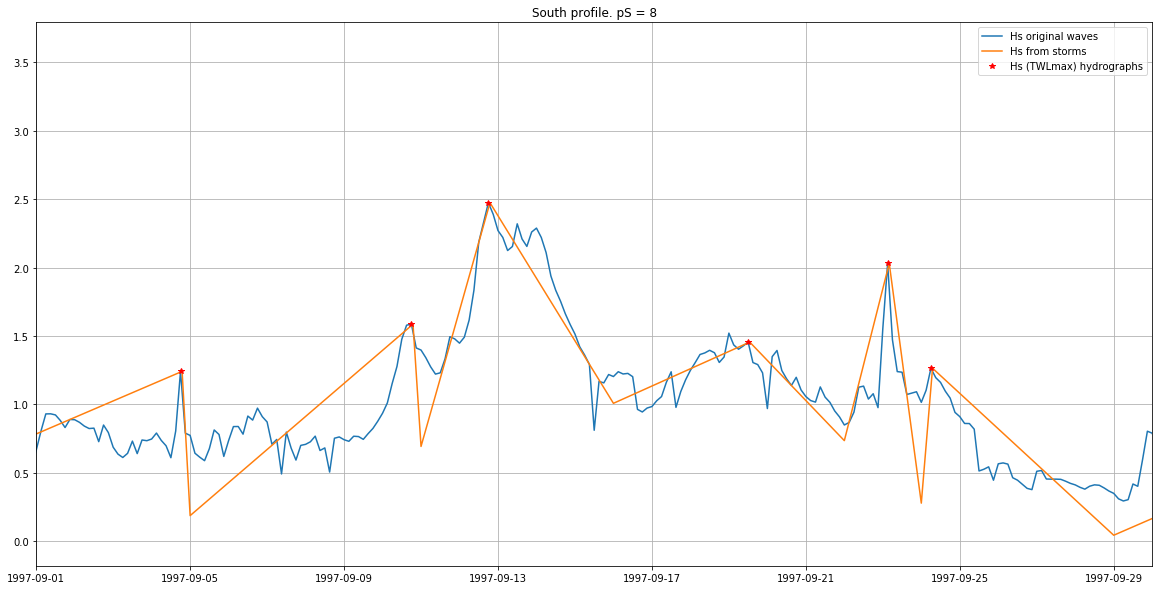

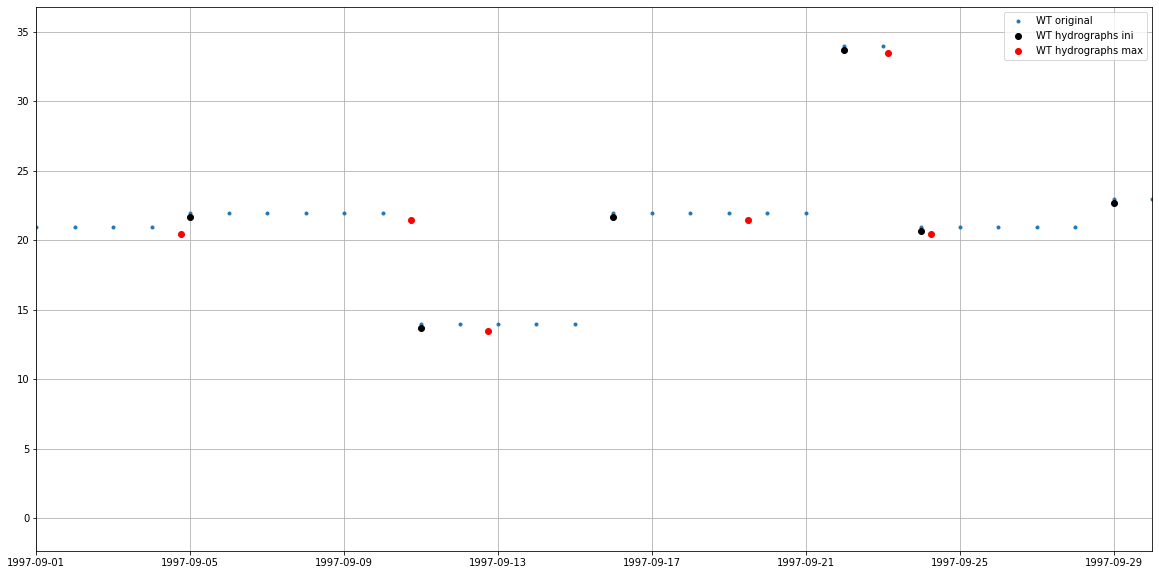

In [10]:
# --------------------------------------
# plot South profile & WTs (1 month zoom)

plt.figure(figsize=(20,10))
plt.plot(WAVES_S_h.time, WAVES_S_h.hs, label='Hs original waves')
plt.plot(WAVES_S.time, WAVES_S.Hs, label='Hs from storms')
plt.plot(xds_mutau_S.time_runup_max, xds_mutau_S.Hs, '*r', label='Hs (TWLmax) hydrographs')
plt.legend()
plt.grid()
plt.xlim(datetime(1997,9,1),datetime(1997,9,30))
plt.title('South profile. pS = ' + str(pS))

plt.figure(figsize=(20,10))
plt.plot(WT.time, WT.sorted_bmus,'.', label='WT original')
plt.plot(xds_mutau_S.time, xds_mutau_S.WT-0.3,'ok', label='WT hydrographs ini')
plt.plot(xds_mutau_S.time_runup_max, xds_mutau_S.WT-0.55,'or', label='WT hydrographs max')
plt.xlim(datetime(1997,9,1),datetime(1997,9,30))
plt.legend()
plt.grid()



### plot Tp from storms vs Tp hourly

Text(0.5, 1.0, 'South profile. pS = 8')

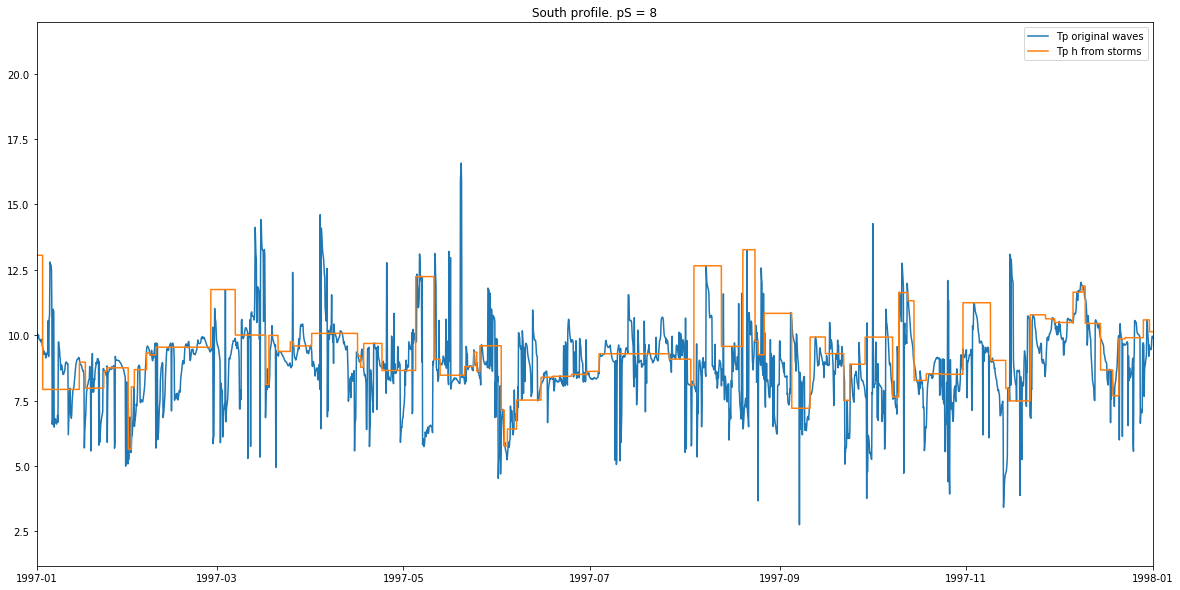

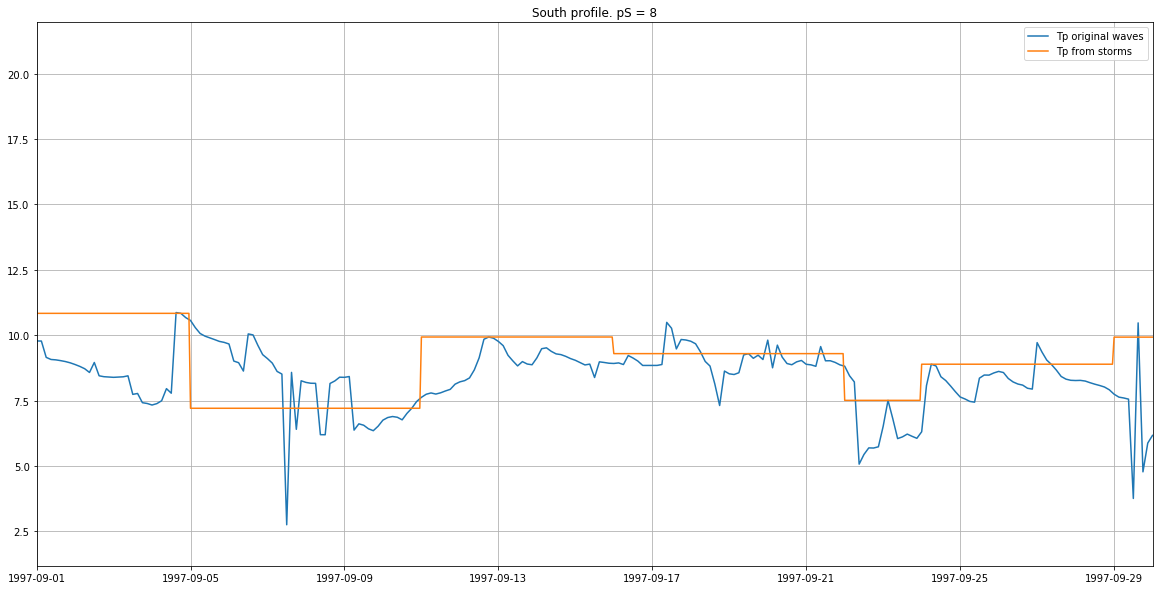

In [11]:
# --------------------------------------
# plot South profile (1 year)

plt.figure(figsize=(20,10))
plt.plot(WAVES_S_h.time, WAVES_S_h.tp, label='Tp original waves')
plt.plot(WAVES_S.time, WAVES_S.Tp, color='C1',label='Tp h from storms')
plt.legend()
plt.xlim(datetime(1997,1,1),datetime(1998,1,1))
plt.title('South profile. pS = ' + str(pS))


# --------------------------------------
# plot South profile & WTs (1 month zoom)

plt.figure(figsize=(20,10))
plt.plot(WAVES_S_h.time, WAVES_S_h.tp, label='Tp original waves')
plt.plot(WAVES_S.time, WAVES_S.Tp, label='Tp from storms')
plt.legend()
plt.grid()
plt.xlim(datetime(1997,9,1),datetime(1997,9,30))
plt.title('South profile. pS = ' + str(pS))


### plot scatter of Hs and Tp. Storms vs hourly (hourly original data)

<xarray.Dataset>
Dimensions:      (time: 119801)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2020-01-01
    profile      float64 8.0
Data variables:
    hs           (time) float64 0.0 0.5151 0.7368 0.8719 ... 1.018 1.781 1.857
    tm           (time) float64 ...
    tp           (time) float64 nan 4.022 5.011 5.641 ... 6.139 13.85 15.81
    dirP         (time) float64 ...
    dir          (time) float64 ...
    dates_sea    (time) float64 ...
    dates_swell  (time) float64 ...
<xarray.Dataset>
Dimensions:  (time: 358657)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-23 1979-01-23T01:00:00 ... 2019-12-23
Data variables:
    Hs       (time) float64 0.888 0.9044 0.9207 0.937 ... 0.2755 0.2688 0.2621
    Tp       (time) float64 9.937 9.937 9.937 9.937 ... 9.679 9.679 9.679 15.16
    Dir      (time) float64 122.1 122.1 122.1 122.1 ... 119.0 119.0 119.0 230.1

<xarray.Dataset>
Dimensions:      (time: 358657)
Coordinates:
    profile      float64 8.0
  * tim

SystemExit: 

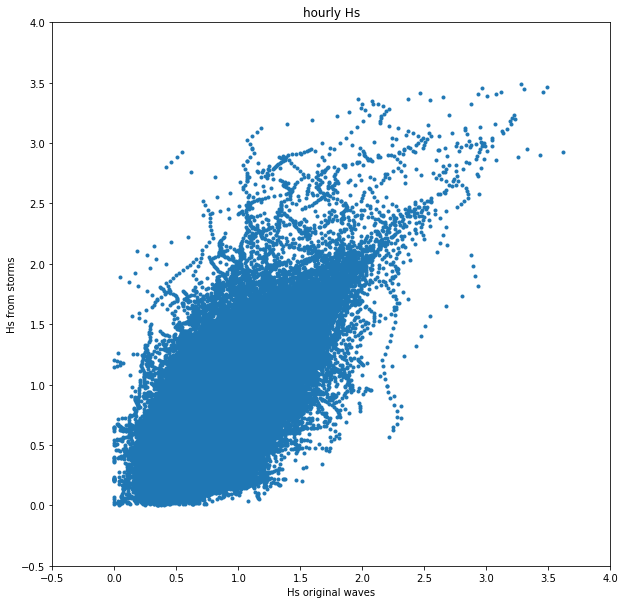

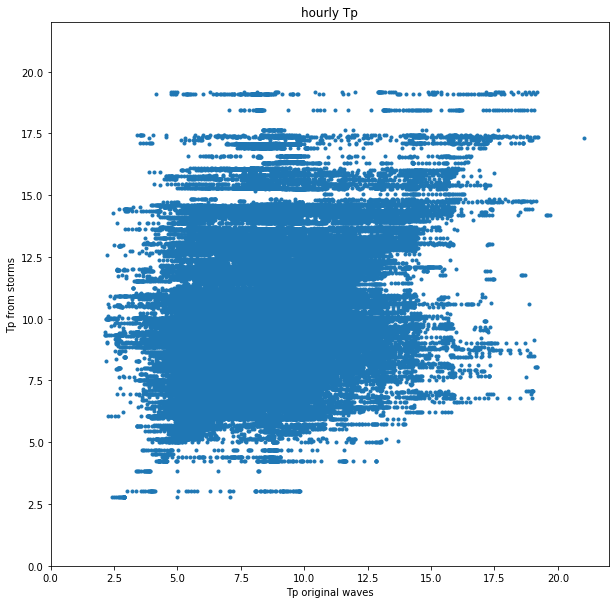

In [12]:

# --------------------------------------
# plot south profile

print(WAVES_S_h) # 3-h
print(WAVES_S) # 1-h
print()

WAVES_S_h = WAVES_S_h.resample(time='1H').interpolate('linear')
WAVES_S_h = WAVES_S_h.sel(time=slice(WAVES_S.time[0],WAVES_S.time[-1]))
print(WAVES_S_h) # 1-h
print(WAVES_S) # 1-h
print()



#WAVES_S_h = WAVES_S_h.sel(time=slice(datetime(1996,1,1), datetime(2014,1,1)))
#WAVES_S = WAVES_S.sel(time=slice(datetime(1996,1,1), datetime(2014,1,1)))




var1 = 'hs'
var2 = 'Hs'
plt.figure(figsize=(10,10))
plt.plot(WAVES_S_h[var1], WAVES_S[var2], '.')
plt.xlabel(var2 + ' original waves')
plt.ylabel(var2 + ' from storms')
plt.xlim(-0.5, 4)
plt.ylim(-0.5, 4)
plt.title('hourly ' + var2)

var1 = 'tp'
var2 = 'Tp'
plt.figure(figsize=(10,10))
plt.plot(WAVES_S_h[var1], WAVES_S[var2], '.')
plt.xlabel(var2 + ' original waves')
plt.ylabel(var2 + ' from storms')
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.title('hourly ' + var2)


from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr
import statistics 

print('alfa=0.3')
print(pearsonr(WAVES_S_h.hs, WAVES_S.Hs))  #{'pearson': 1.0, 'pvalue': 1.0}
print(mean_squared_error(WAVES_S_h.hs, WAVES_S.Hs))

sys.exit()

### plot scatter of Hs and Tp. Storms vs hourly (3-h original data)

<xarray.Dataset>
Dimensions:      (time: 358657)
Coordinates:
    profile      float64 8.0
  * time         (time) datetime64[ns] 1979-01-23 ... 2019-12-23
Data variables:
    hs           (time) float64 1.659 1.61 1.561 1.511 ... 0.8055 0.7765 0.7475
    tm           (time) float64 7.285 7.3 7.315 7.331 ... 7.314 7.2 7.085 6.971
    tp           (time) float64 8.488 8.547 8.607 8.666 ... 8.525 8.295 8.066
    dirP         (time) float64 117.8 118.4 119.0 119.6 ... 110.3 108.2 106.0
    dir          (time) float64 118.2 118.9 119.6 120.3 ... 125.0 124.7 124.4
    dates_sea    (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 0.6667 0.3333 0.0
    dates_swell  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
<xarray.Dataset>
Dimensions:  (time: 358657)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-23 1979-01-23T01:00:00 ... 2019-12-23
Data variables:
    Hs       (time) float64 0.888 0.9044 0.9207 0.937 ... 0.2755 0.2688 0.2621
    Tp       (time) float64 9.937 9.937 9.

SystemExit: 

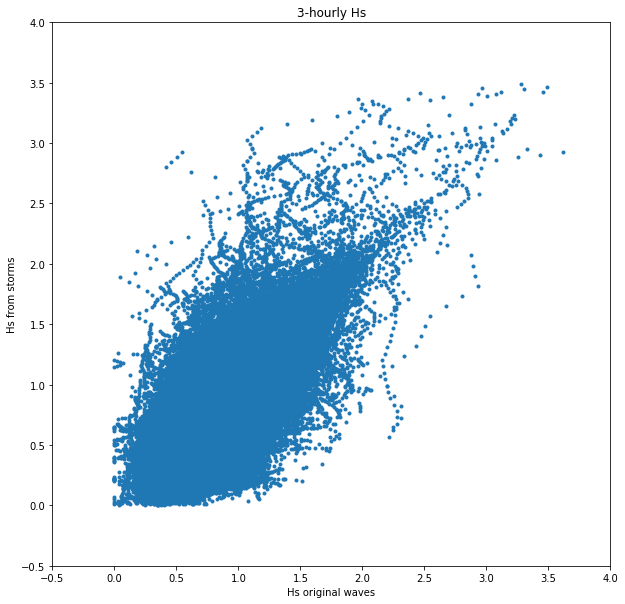

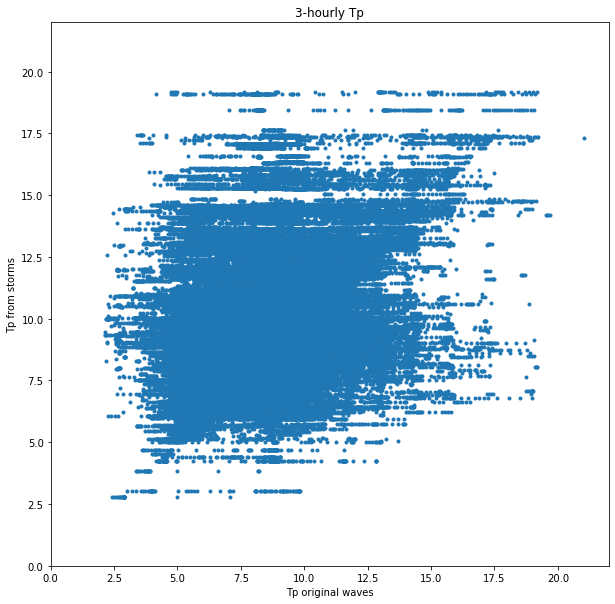

In [13]:
# --------------------------------------
# plot south profile

print(WAVES_S_h) # 3-h
print(WAVES_S) # 1-h
print()

WAVES_S_h = WAVES_S_h.sel(time=slice(WAVES_S.time[0],WAVES_S.time[-1]))
WAVES_S = WAVES_S.sel(time=WAVES_S_h.time)
print(WAVES_S_h) # 3-h
print(WAVES_S) # 3-h
print()

var1 = 'hs'
var2 = 'Hs'
plt.figure(figsize=(10,10))
plt.plot(WAVES_S_h[var1], WAVES_S[var2], '.')
plt.xlabel(var2 + ' original waves')
plt.ylabel(var2 + ' from storms')
plt.xlim(-0.5, 4)
plt.ylim(-0.5, 4)
plt.title('3-hourly ' + var2)

var1 = 'tp'
var2 = 'Tp'
plt.figure(figsize=(10,10))
plt.plot(WAVES_S_h[var1], WAVES_S[var2], '.')
plt.xlabel(var2 + ' original waves')
plt.ylabel(var2 + ' from storms')
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.title('3-hourly ' + var2)


sys.exit()


## Hycreww RBF Interpolation

##### Set parameters for Hycreww: TWL, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf

In [14]:

dset_N = xr.Dataset(
            {   'hs':(('time'), WAVES_N.Hs.values),
                'tp':(('time'), WAVES_N.Tp.values),
                'bslope':(('time'), np.ones(len(WAVES_N.time),)*reef_N['Beach Slope'].values),
                'rslope':(('time'), np.ones(len(WAVES_N.time),)*reef_N['Fore Slope'].values),
                'rwidth':(('time'), np.ones(len(WAVES_N.time),)*reef_N['Wreef'].values),
                'Zb':(('time'), np.ones(len(WAVES_N.time),)*Zbeach_N['zBeach'].values),
                'cf':(('time'), np.ones(len(WAVES_N.time),)*0.1),
            },coords = {'time': WAVES_N.time.values})

dset_S = xr.Dataset(
            {   'hs':(('time'), WAVES_S.Hs.values),
                'tp':(('time'), WAVES_S.Tp.values),
                'bslope':(('time'), np.ones(len(WAVES_S.time),)*reef_S['Beach Slope'].values),
                'rslope':(('time'), np.ones(len(WAVES_S.time),)*reef_S['Fore Slope'].values),
                'rwidth':(('time'), np.ones(len(WAVES_S.time),)*reef_S['Wreef'].values),
                'Zb':(('time'), np.ones(len(WAVES_S.time),)*Zbeach_S['zBeach'].values),
                'cf':(('time'), np.ones(len(WAVES_S.time),)*0.1),
            },coords = {'time': WAVES_S.time.values})

dset_E = xr.Dataset(
            {   'hs':(('time'), WAVES_E.Hs.values),
                'tp':(('time'), WAVES_E.Tp.values),
                'bslope':(('time'), np.ones(len(WAVES_E.time),)*reef_E['Beach Slope'].values),
                'rslope':(('time'), np.ones(len(WAVES_E.time),)*reef_E['Fore Slope'].values),
                'rwidth':(('time'), np.ones(len(WAVES_E.time),)*reef_E['Wreef'].values),
                'Zb':(('time'), np.ones(len(WAVES_E.time),)*Zbeach_E['zBeach'].values),
                'cf':(('time'), np.ones(len(WAVES_E.time),)*0.1),
            },coords = {'time': WAVES_E.time.values})

dset_N = dset_N.sel(time=slice(dset_N.time.values[0],hist_TWL.time.values[-1]))
dset_S = dset_S.sel(time=slice(dset_N.time.values[0],hist_TWL.time.values[-1]))
dset_E = dset_E.sel(time=slice(dset_N.time.values[0],hist_TWL.time.values[-1]))

dset_N['level'] = hist_TWL.TWL.sel(time=dset_N.time)
dset_S['level'] = hist_TWL.TWL.sel(time=dset_S.time)
dset_E['level'] = hist_TWL.TWL.sel(time=dset_E.time)

dset_N['hs_lo2'] = (dset_N.hs/(1.5613*dset_N.tp**2))
dset_S['hs_lo2'] = (dset_S.hs/(1.5613*dset_S.tp**2))
dset_E['hs_lo2'] = (dset_E.hs/(1.5613*dset_E.tp**2))

print(dset_N)
print(dset_S)
print(dset_E)

<xarray.Dataset>
Dimensions:    (time: 349740)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-23 ... 2018-12-16T11:00:00
    longitude  float32 ...
    latitude   float32 ...
Data variables:
    hs         (time) float64 0.07212 0.08197 0.09181 ... 0.087 0.08338 0.07975
    tp         (time) float64 3.545 3.545 3.545 3.545 ... 3.458 3.458 3.458
    bslope     (time) float64 0.3 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
    rslope     (time) float64 0.02 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02 0.02
    rwidth     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Zb         (time) float64 2.15 2.15 2.15 2.15 2.15 ... 2.15 2.15 2.15 2.15
    cf         (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    level      (time) float64 ...
    hs_lo2     (time) float64 0.003675 0.004177 0.004678 ... 0.004466 0.004272
<xarray.Dataset>
Dimensions:    (time: 349740)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-23 ... 2018-12-16T11:00:00
    l

In [15]:
# Adjust variables to fit within Hycreww limits

for var in var_lims.keys():

    dset_N[var] =  dset_N[var].where(dset_N[var]>=var_lims[var][0], var_lims[var][0] )
    dset_N[var] =  dset_N[var].where(dset_N[var]<=var_lims[var][1], var_lims[var][1] )    
    
    dset_S[var] =  dset_S[var].where(dset_S[var]>=var_lims[var][0], var_lims[var][0] )
    dset_S[var] =  dset_S[var].where(dset_S[var]<=var_lims[var][1], var_lims[var][1] )    
    
    dset_E[var] =  dset_E[var].where(dset_E[var]>=var_lims[var][0], var_lims[var][0] )
    dset_E[var] =  dset_E[var].where(dset_E[var]<=var_lims[var][1], var_lims[var][1] )    
    
print(dset_N)
print(dset_S)
print(dset_E)


<xarray.Dataset>
Dimensions:    (time: 349740)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-23 ... 2018-12-16T11:00:00
    longitude  float32 ...
    latitude   float32 ...
Data variables:
    hs         (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    tp         (time) float64 3.545 3.545 3.545 3.545 ... 3.458 3.458 3.458
    bslope     (time) float64 0.2 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    rslope     (time) float64 0.05 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05 0.05
    rwidth     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Zb         (time) float64 2.15 2.15 2.15 2.15 2.15 ... 2.15 2.15 2.15 2.15
    cf         (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    level      (time) float64 0.1451 0.1167 0.03166 ... -0.01362 0.05257 0.07566
    hs_lo2     (time) float64 0.005 0.005 0.005 0.00518 ... 0.005 0.005 0.005
<xarray.Dataset>
Dimensions:    (time: 349740)
Coordinates:
  * time       (time) datetime64[

### HyCReWW-Q

In [16]:
# HyCReWW Function

def hycreww_Q(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (WL, Hs, Tp, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf )
    
    '''
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'Zb', 'cf']

    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4, 5]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]


    # discard data outside limits
#     for vn in var_lims.keys():
#         dset = dset.isel(num=np.where((dset[vn] >= var_lims[vn][0]) & (dset[vn] <= var_lims[vn][1]))[0])


    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]
    ds_in=([dset.level.values],[dset.rslope.values],[dset.bslope.values],[dset.rwidth.values],[dset.Zb.values],[dset.cf.values])
    ds_in=np.transpose(ds_in)[:,0,:]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)

    # Q Linear interpolation (hs, hs_lo -> runup)
    Q = []
    for c  in range(len(dset.time)):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (dset.hs.values[c], dset.hs_lo2.values[c]), method='linear')
        Q.append(vq)
    Q = np.array(Q)

    # store runup alongside input data
    dset_out = dset.copy()  
    dset_out['Q'] = (('time'),Q)

    return dset_out

In [ ]:
out_sim_N = hycreww_Q(var_lims, rbf_coeffs, dset_N)
print(out_sim_N)

out_sim_S = hycreww_Q(var_lims, rbf_coeffs, dset_S)
print(out_sim_S)

out_sim_E = hycreww_Q(var_lims, rbf_coeffs, dset_E)
print(out_sim_E)


### We undo the box-cox transformation

In [ ]:
from scipy.special import boxcox, inv_boxcox

# inv_boxcox(y, lmbda) 
# y = (x**lmbda - 1) / lmbda  if lmbda != 0
#     log(x)                  if lmbda == 0
    
out_sim_N['Qinv']=inv_boxcox(out_sim_N.Q.values, 0.2)
out_sim_S['Qinv']=inv_boxcox(out_sim_S.Q.values, 0.2)
out_sim_E['Qinv']=inv_boxcox(out_sim_E.Q.values, 0.2)

In [ ]:
print(out_sim_E)

In [ ]:
# Save
out_sim_N.to_netcdf(op.join(p_data, 'sites/KWAJALEIN_hindcast/HYCREWW/hist_Q_storms_N' + str(pN) + '.nc'))
out_sim_S.to_netcdf(op.join(p_data, 'sites/KWAJALEIN_hindcast/HYCREWW/hist_Q_storms_S' + str(pS) + '.nc'))
out_sim_E.to_netcdf(op.join(p_data, 'sites/KWAJALEIN_hindcast/HYCREWW/hist_Q_storms_E' + str(pE) + '.nc'))


### Plot

In [17]:

out_sim_N = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN_hindcast/HYCREWW/val_storms_method/hist_Q_storms_N' + str(pN) + '.nc'))
out_sim_S = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN_hindcast/HYCREWW/val_storms_method/hist_Q_storms_S' + str(pS) + '.nc'))
out_sim_E = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN_hindcast/HYCREWW/val_storms_method/hist_Q_storms_E' + str(pE) + '.nc'))

print(out_sim_N)
print(out_sim_S)
print(out_sim_E)

<xarray.Dataset>
Dimensions:  (Qinv: 349740, time: 349740)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-23 ... 2018-12-16T11:00:00
  * Qinv     (Qinv) float64 9.952e-05 4.635e-05 ... 6.678e-06 1.385e-05
Data variables:
    hs       (time) float64 ...
    tp       (time) float64 ...
    bslope   (time) float64 ...
    rslope   (time) float64 ...
    rwidth   (time) float64 ...
    Zb       (time) float64 ...
    cf       (time) float64 ...
    level    (time) float64 ...
    hs_lo2   (time) float64 ...
    Q        (time) float64 ...
<xarray.Dataset>
Dimensions:  (Qinv: 349740, time: 349740)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-23 ... 2018-12-16T11:00:00
  * Qinv     (Qinv) float64 5.839e-05 3.935e-05 ... 1.843e-05 2.581e-05
Data variables:
    hs       (time) float64 ...
    tp       (time) float64 ...
    bslope   (time) float64 ...
    rslope   (time) float64 ...
    rwidth   (time) float64 ...
    Zb       (time) float64 ...
    cf       (time) float64 

Text(0.5, 0.98, 'Overtopping (l/s/m)')

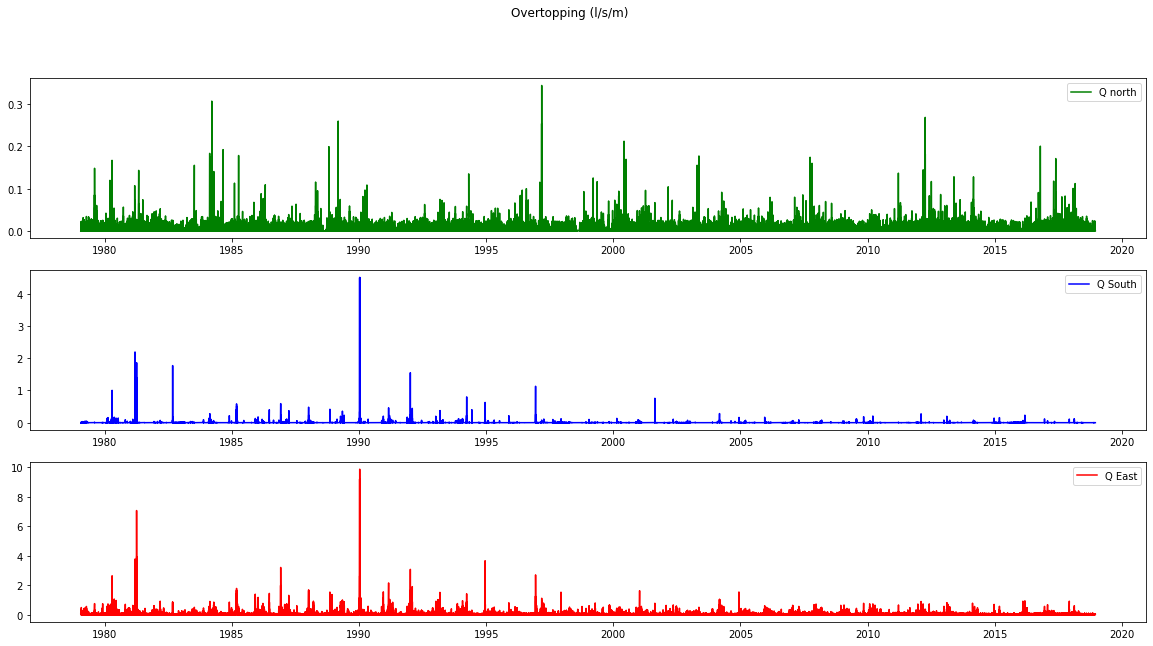

In [19]:
fig, axs = plt.subplots(3,1, figsize=(20,10))
axs[0].plot(out_sim_N.time, out_sim_N.Qinv, color='g', label='Q north')
axs[1].plot(out_sim_S.time, out_sim_S.Qinv, color='b', label='Q South')
axs[2].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.suptitle('Overtopping (l/s/m)')



#fig, axs = plt.subplots(3,1, figsize=(20,10))
#axs[0].plot(out_sim_N.time, out_sim_N.Q, label='Q north')
#axs[1].plot(out_sim_S.time, out_sim_S.Q, label='Q South')
#axs[2].plot(out_sim_E.time, out_sim_E.Q, label='Q East')
#plt.suptitle('Overtopping (l/s/m)')

#### Plot results for East profile

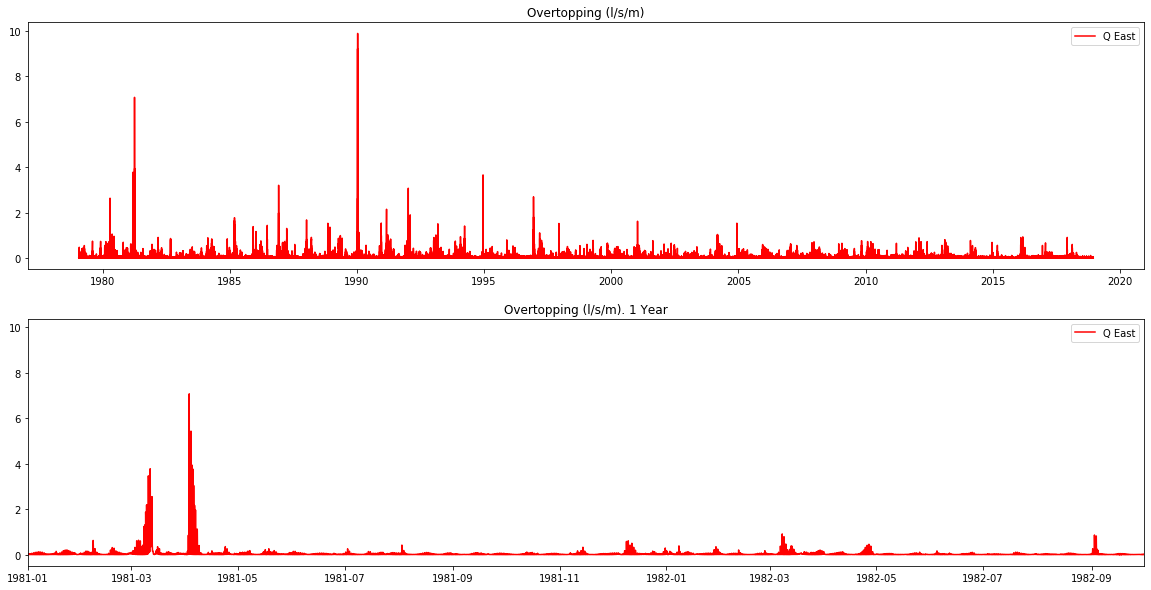

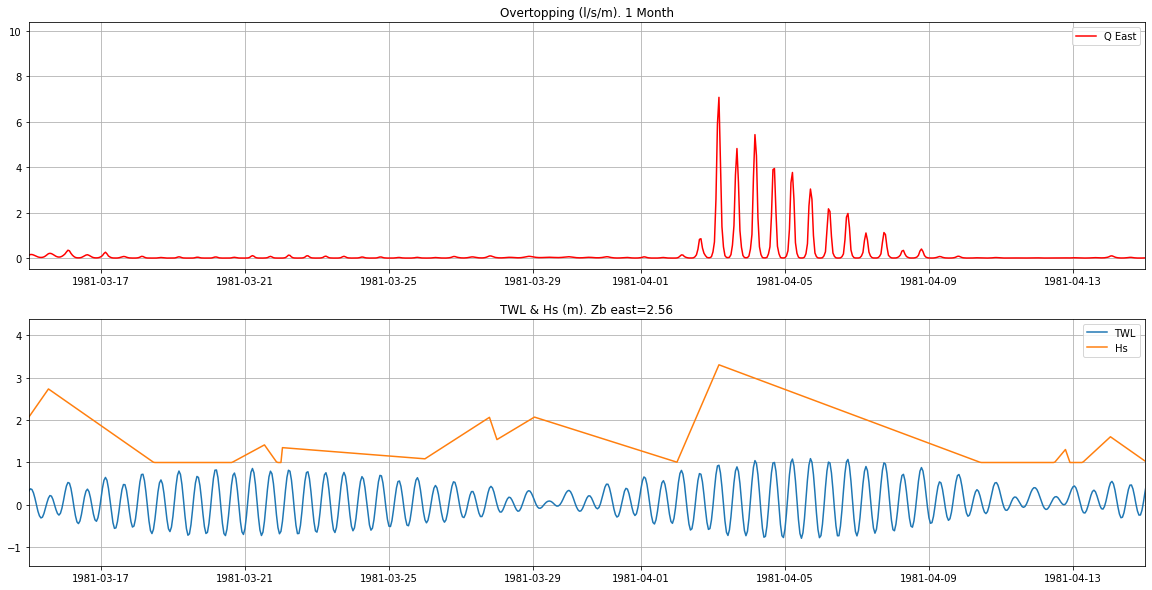

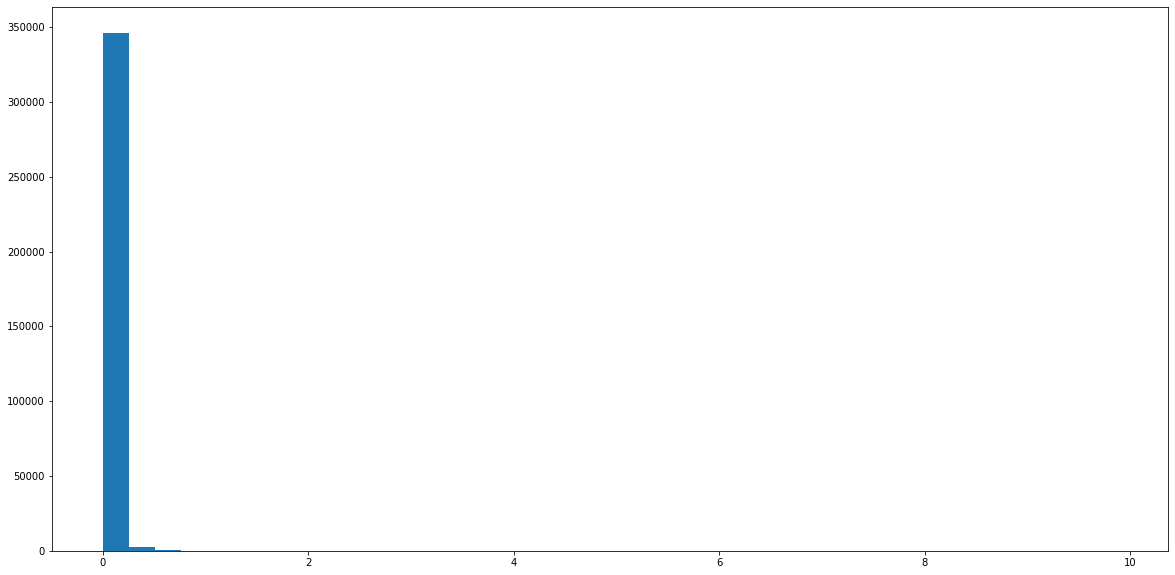

[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100. ]

[1.25072000e-24 5.30302870e-06 1.86306166e-05 4.09853619e-05
 7.52536544e-05 1.23233986e-04 1.84859774e-04 2.62218747e-04
 3.55773728e-04 4.71305675e-04 6.05510665e-04 7.59546280e-04
 9.43354025e-04 1.15197890e-03 1.39885118e-03 1.68259818e-03
 2.01300698e-03 2.38251974e-03 2.80233926e-03 3.28237803e-03
 3.82864911e-03 4.42302835e-03 5.11278970e-03 5.88364839e-03
 6.74638907e-03 7.71457962e-03 8.82976351e-03 1.00699195e-02
 1.15172601e-02 1.32294841e-02 1.52204407e-02 1.76497182e-02
 2.06368158e-02 2.42889994e-02 2.88506071e-02 3.48880463e-02
 4.28830500e-02 5.45305681e-02 7.47615364e-02 1.27105030e-01
 9.87419430e+00]


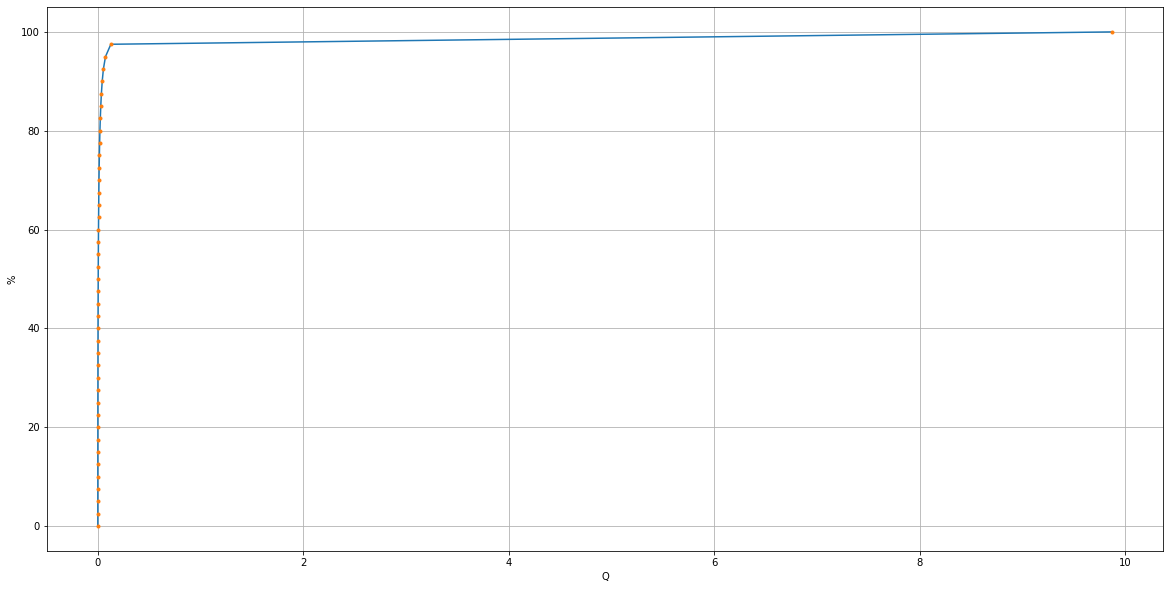

In [20]:
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[0].set_title('Overtopping (l/s/m)')

# zoom 1 year
axs[1].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[1].legend()
axs[1].set_title('Overtopping (l/s/m). 1 Year')
#axs[1].set_xlim(datetime(2000,10,1),datetime(2001,10,1))
axs[1].set_xlim(datetime(1981,1,1),datetime(1982,10,1))

# zoom 1 month
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[0].set_title('Overtopping (l/s/m). 1 Month')
#axs[0].set_xlim(datetime(2001,1,1),datetime(2001,2,1))
axs[0].set_xlim(datetime(1981,3,15),datetime(1981,4,15))
axs[0].grid()

# plot TWL
axs[1].plot(hist_TWL.time, hist_TWL.TWL, label = 'TWL')
axs[1].plot(out_sim_E.time, out_sim_E.hs, label = 'Hs')
axs[1].legend()
#axs[1].set_xlim(datetime(2001,1,1),datetime(2001,2,1))
axs[1].set_xlim(datetime(1981,3,15),datetime(1981,4,15))
#axs[1].set_ylim(-1, 2.5)
axs[1].set_title('TWL & Hs (m). Zb east=' + str(round(out_sim_E.Zb.values[0],2)))
axs[1].grid()


# histogram
plt.figure(figsize=(20,10))
bins_number = 40 #100 
bins = np.linspace(np.nanmin(out_sim_E.Qinv.values), np.nanmax(out_sim_E.Qinv.values), bins_number)

n, _, _ = plt.hist(out_sim_E.Qinv.values, bins)
plt.show()

# percentiles
q = np.linspace(0,100,bins_number+1)
perc = np.nanpercentile(out_sim_E.Qinv.values, q)

plt.figure(figsize=(20,10))
plt.plot(perc, q)
plt.plot(perc, q, '.')
plt.xlabel('Q')
plt.ylabel('%')
plt.grid()

print(q)
print()
print(perc)

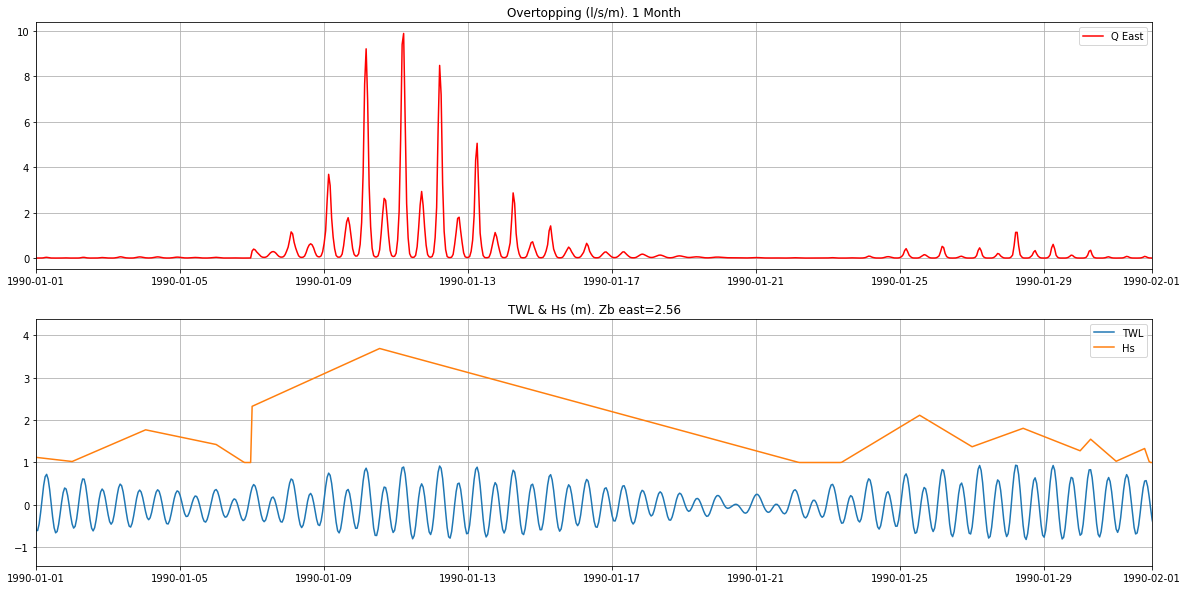

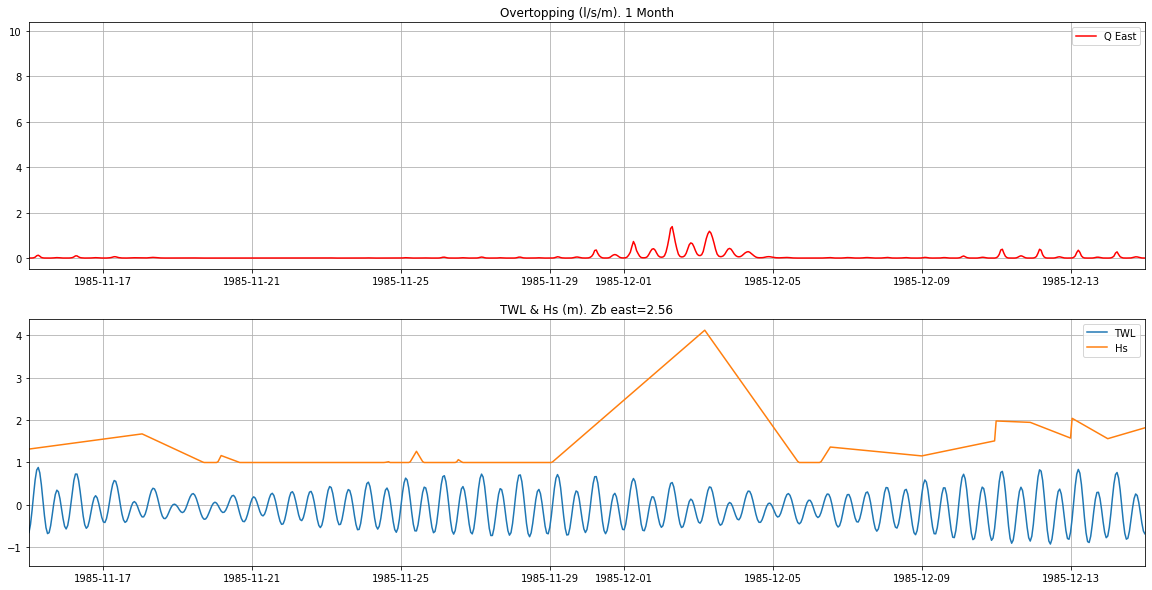

In [21]:
#----------------------------------------
# plot max overtopping

# zoom 1 month
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[0].set_title('Overtopping (l/s/m). 1 Month')
axs[0].set_xlim(datetime(1990,1,1),datetime(1990,2,1))
axs[0].grid()

# plot TWL
axs[1].plot(hist_TWL.time, hist_TWL.TWL, label = 'TWL')
axs[1].plot(out_sim_E.time, out_sim_E.hs, label = 'Hs')
axs[1].legend()
axs[1].set_xlim(datetime(1990,1,1),datetime(1990,2,1))
#axs[1].set_ylim(-1, 2.5)
axs[1].set_title('TWL & Hs (m). Zb east=' + str(round(out_sim_E.Zb.values[0],2)))
axs[1].grid()


#----------------------------------------
# plot max Hs

# zoom 1 month
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[0].set_title('Overtopping (l/s/m). 1 Month')
axs[0].set_xlim(datetime(1985,11,15),datetime(1985,12,15))
axs[0].grid()

# plot TWL
axs[1].plot(hist_TWL.time, hist_TWL.TWL, label = 'TWL')
axs[1].plot(out_sim_E.time, out_sim_E.hs, label = 'Hs')
axs[1].legend()
axs[1].set_xlim(datetime(1985,11,15),datetime(1985,12,15))
#axs[1].set_ylim(-1, 2.5)
axs[1].set_title('TWL & Hs (m). Zb east=' + str(round(out_sim_E.Zb.values[0],2)))
axs[1].grid()

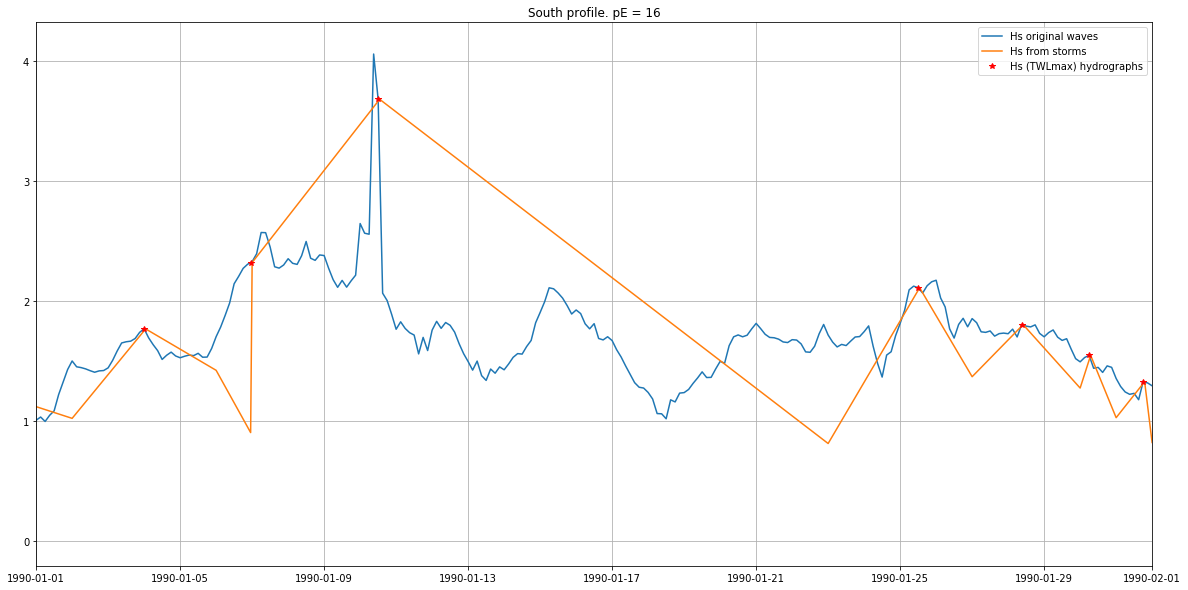

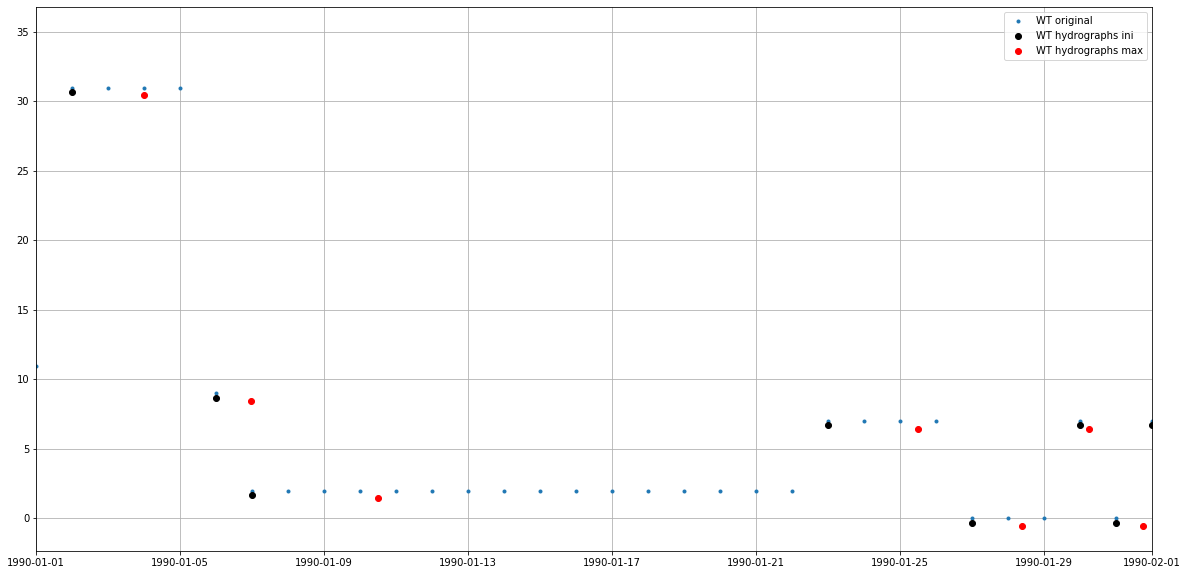

In [22]:

plt.figure(figsize=(20,10))
plt.plot(WAVES_E_h.time, WAVES_E_h.hs, label='Hs original waves')
plt.plot(WAVES_E.time, WAVES_E.Hs, label='Hs from storms')
plt.plot(xds_mutau_E.time_runup_max, xds_mutau_E.Hs, '*r', label='Hs (TWLmax) hydrographs')
plt.legend()
plt.grid()
plt.xlim(datetime(1990,1,1),datetime(1990,2,1))
#plt.xlim(datetime(1997,6,15),datetime(1997,8,15))
plt.title('South profile. pE = ' + str(pE))

plt.figure(figsize=(20,10))
plt.plot(WT.time, WT.sorted_bmus,'.', label='WT original')
plt.plot(xds_mutau_E.time, xds_mutau_E.WT-0.3,'ok', label='WT hydrographs ini')
plt.plot(xds_mutau_E.time_runup_max, xds_mutau_E.WT-0.55,'or', label='WT hydrographs max')
plt.xlim(datetime(1990,1,1),datetime(1990,2,1))
#plt.xlim(datetime(1997,6,15),datetime(1997,8,15))
plt.legend()
plt.grid()


In [23]:
WT = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_05/ESTELA/pred_SLP/kma.nc')
print(WT)

dif_bmus = np.diff(WT.sorted_bmus)
#dif_bmus = np.diff(WT.sorted_bmus_storms)
print(np.shape(dif_bmus))

dif_bmus = np.nonzero(dif_bmus)
dif_bmus = np.diff(dif_bmus)

print(np.min(dif_bmus))
print(np.max(dif_bmus))

<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 14953, n_features: 152)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 ...
    cenEOFs             (n_clusters, n_features) float64 ...
    centroids           (n_clusters, n_features) float64 ...
    group_size          (n_clusters) int64 ...
    sorted_order        (n_clusters) int64 ...
    sorted_bmus         (n_components) int64 ...
    sorted_cenEOFs      (n_clusters, n_features) float64 ...
    sorted_centroids    (n_clusters, n_features) float64 ...
    time                (n_components) datetime64[ns] ...
    sorted_bmus_storms  (n_components) int64 ...
Attributes:
    method:   regression guided
    alpha:    0.5
(14952,)
1
40
